In [ ]:
# !pip install import-ipynb
# import import_ipynb

%tensorflow_version 1.x
!pip install numpy==1.16.1

     |████████████████████████████████| 17.3MB 200kB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [1]:
!pip install import-ipynb
import import_ipynb
import numpy as np
from sklearn.metrics import r2_score,accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras.models import Model,Sequential 
import warnings
from keras import backend as K
from keras import Input,layers,optimizers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,Dropout,Reshape,\
    BatchNormalization,Flatten,Conv2D,AveragePooling2D,GlobalAveragePooling2D,MaxPooling2D,GlobalMaxPooling2D,DepthwiseConv2D
from keras.applications.imagenet_utils import decode_predictions
from sklearn.utils import shuffle
from keras.layers.merge import concatenate 
from keras.applications import VGG16, InceptionV3, MobileNet, ResNet50, DenseNet121
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input 
from keras.applications.inception_v3 import preprocess_input
from keras.applications.mobilenet import preprocess_input
from keras.applications.resnet import preprocess_input
from keras.applications.densenet import preprocess_input
from google.colab import drive
from keras.utils.vis_utils import plot_model




drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks"
from model_functions import *

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=45b606d23bc97872b0847f6a3293eca49cfd4848039b7680fef4b6d474f24add
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEyXGcejmoSp4Y9JUhFci-iZaiy2XqAC8T4bSXyTFrSMCB4QITR0MI
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
importing Jupyter notebook from model_functions.ipynb


# 从这里开始

In [2]:
def sixtothree_matrix(all_data):   #把 6个频道变成3个频道 
  L = []
  for i in range(150):
    New = []

    Delta = 0

    alfa = 0

    Beta = 0
    for j in range(0,2):
      Delta = Delta + all_data[i,j,:,:]
    Delta = Delta/2

    for j in range(2,4):
      alfa = alfa + all_data[i,j,:,:]
    alfa = alfa/2
 
    for j in range(4,6):
      Beta = Beta + all_data[i,j,:,:]
    Beta = Beta/2
    New.append(Delta)

    New.append(alfa)

    New.append(Beta)

    L.append(New)
  New = np.array(L)
  return New

In [3]:
data = []
label2 = []
label3 = []
for i in range(1,25):
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i) +'_flipped.npy',allow_pickle= True)
  b = sixtothree_matrix(a)
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(i) + '.npy',allow_pickle= True)  #直接4输出 （2个class）
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_2_' + str(i) + '.npy',allow_pickle= True)  #4个3label
  data.append(b)
  label2.append(c)
  label3.append(d)

In [4]:
# 按照病人打乱顺序
Data, Label2, Label3 = shuffle(data, label2, label3, random_state = 20)

# 将shuffle后的数据的前20个病人数据做训练+验证集
train_val_data = Data[:20]
train_val_label2 = Label2[:20] 
train_val_label3 = Label3[:20] 


# 将shuffle后的数据的后4个病人数据做测试集
test_data = Data[20:]
test_label2 = Label2[20:]
test_label3 = Label3[20:]

train_data = np.array(train_val_data, dtype=np.float)
train_data = np.reshape(train_data,(3000,116,116,3))

train_label2 = np.array(train_val_label2, dtype=np.float)
train_label2 = np.reshape(train_label2,(3000,4))

train_label3 = np.array(train_val_label3, dtype=np.float)
train_label3 = np.reshape(train_label3,(3000,4,2))


test_data = np.array(test_data, dtype=np.float)
test_data = np.reshape(test_data,(600,116,116,3))

test_label2 = np.array(test_label2, dtype=np.float)
test_label2 = np.reshape(test_label2,(600,4))

test_label3 = np.array(test_label3, dtype=np.float)
test_label3 = np.reshape(test_label3,(600,4,2))


Train_data, Train_label2, Train_label3= shuffle(train_data, train_label2, train_label3,random_state = 20)
# Train_data, Train_label3 = shuffle(train_data,  random_state = 20)

In [45]:
print(Train_label3[:1])

[[[0. 1.]
  [0. 1.]
  [0. 1.]
  [1. 0.]]]


In [ ]:
print(Train_data.shape)

(3000, 116, 116, 3)


In [ ]:
# 按照病人打乱顺序
Data, Label2, Label3 = shuffle(data, label2, label3, random_state = 20)

# 将shuffle后的数据的前20个病人数据做训练+验证集
train_val_data = Data[:20]
train_val_label2 = Label2[:20] 
train_val_label3 = Label3[:20] 

train_data = train_val_data[:16]
val_data = train_val_data[16:]

train_label2 = train_val_label2[:16]
val_label2 = train_val_label2[16:]

train_label3 = train_val_label3[:16]
val_label3 = train_val_label3[16:]


# 将shuffle后的数据的后4个病人数据做测试集
test_data = Data[20:]
test_label2 = Label2[20:]
test_label3 = Label3[20:]

train_data = np.array(train_data, dtype=np.float)
train_data = np.reshape(train_data,(2400,116,116,3))

val_data = np.array(val_data, dtype=np.float)
val_data = np.reshape(val_data,(600,116,116,3))

train_label2 = np.array(train_label2, dtype=np.float)
train_label2 = np.reshape(train_label2,(2400,4))

val_label2 = np.array(val_label2, dtype=np.float)
val_label2 = np.reshape(val_label2,(600,4))

train_label3 = np.array(train_label3, dtype=np.float)
train_label3 = np.reshape(train_label3,(2400,4,3))

val_label3 = np.array(val_label3, dtype=np.float)
val_label3 = np.reshape(val_label3,(600,4,3))


test_data = np.array(test_data, dtype=np.float)
test_data = np.reshape(test_data,(600,116,116,3))

test_label2 = np.array(test_label2, dtype=np.float)
test_label2 = np.reshape(test_label2,(600,4))

test_label3 = np.array(test_label3, dtype=np.float)
test_label3 = np.reshape(test_label3,(600,4,3))




#VGG16

In [116]:
def V16():
  from keras.applications.vgg16 import VGG16
  from keras.preprocessing import image
  from keras.applications.vgg16 import preprocess_input 
  initializer = tf.keras.initializers.Zeros()
  # model = VGG16(weights='imagenet', include_top=False) 
  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(116,116,3))
  x = conv_base.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu',kernel_initializer= initializer)(x)
  x = Dense(512, activation='relu',kernel_initializer= initializer)(x)  
  # x = Dense(256, activation='relu')(x) 
  # x = Dense(128, activation='relu')(x) 
  # x = Dense(64, activation='relu')(x)
  # x = Dense(3, activation='softmax')(x) 
  x = Dense(4, activation = 'sigmoid',kernel_initializer=initializer)(x) 

  model = Model(inputs=conv_base.input, outputs=x)
#首先，我们只训练顶部的几层（随机初始化的层）
  # for layer in conv_base.layers:
  #   layer.trainable = False
  model.summary()
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy']) 
             
  return model
  



# ResNet50

In [117]:
def ResNet50(): #训练集 效果较好

  from keras.applications.resnet50 import ResNet50
  from keras.preprocessing import image
  from keras.applications.resnet50 import preprocess_input
  initializer = tf.keras.initializers.Zeros()

  conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(116, 116, 3))

  x = conv_base.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)  
  # x = Dense(256, activation='relu')(x) 
  # x = Dense(128, activation='relu')(x) 
  # x = Dense(64, activation='relu')(x)
  # x = Dense(3, activation='softmax')(x) 
  # x = Dense(3, kernel_initializer=initializer,activation='sigmoid')(x) 
  x = Dense(4, activation = 'sigmoid',kernel_initializer=initializer)(x) 

  model = Model(inputs=conv_base.input, outputs=x)
# 首先，我们只训练顶部的几层（随机初始化的层）
  # for layer in conv_base.layers:
  #   layer.trainable = False
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/images/resnet50.png', show_shapes=True, show_layer_names=True)
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model
  
  





# Xception

In [118]:
def Xception():

  from keras.applications.xception import Xception
  from keras.preprocessing import image
  from keras.applications.xception  import preprocess_input
  initializer = tf.keras.initializers.Zeros()
  # model = VGG16(weights='imagenet', include_top=False) 
  conv_base = Xception(weights='imagenet', include_top=False, input_shape=(116, 116, 3))
  x = conv_base.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)  
  # x = Dense(256, activation='relu')(x) 
  # x = Dense(128, activation='relu')(x) 
  # x = Dense(64, activation='relu')(x)
  # x = Dense(3, activation='softmax')(x)
  x = Dense(4, activation = 'sigmoid',kernel_initializer=initializer)(x) 

  model = Model(inputs=conv_base.input, outputs=x)
# 首先，我们只训练顶部的几层（随机初始化的层）
  # for layer in conv_base.layers:
  #   layer.trainable = False
  model.summary()
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model


# DenseNet121

In [119]:
def DenseNet121():

  from keras.applications.densenet import DenseNet121
  from keras.preprocessing import image
  from keras.applications.densenet import preprocess_input
  initializer = tf.keras.initializers.Zeros()
  # model = VGG16(weights='imagenet', include_top=False) 
  conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(116, 116, 3))
  x = conv_base.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)  
  # x = Dense(256, activation='relu')(x) 
  # x = Dense(128, activation='relu')(x) 
  # x = Dense(64, activation='relu')(x)
  # x = Dense(3, activation='softmax')(x) 
  x = Dense(4, activation = 'sigmoid',kernel_initializer=initializer)(x) 

  model = Model(inputs=conv_base.input, outputs=x)
  model.summary()
# 首先，我们只训练顶部的几层（随机初始化的层）
  # for layer in conv_base.layers:
  #   layer.trainable = False
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model

# MobileNet

In [120]:
def MobileNet(): #效果也不错

  from keras.applications.mobilenet import MobileNet
  from keras.preprocessing import image
  from keras.applications.mobilenet  import preprocess_input
  # model = VGG16(weights='imagenet', include_top=False) 
  initializer = tf.keras.initializers.Zeros()
  conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(116, 116, 3))
  x = conv_base.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)  
  # x = Dense(256, activation='relu')(x) 
  # x = Dense(128, activation='relu')(x) 
  # x = Dense(64, activation='relu')(x)
  # x = Dense(3, activation='softmax')(x) 
  x = Dense(4, activation = 'sigmoid',kernel_initializer=initializer)(x) 

  model = Model(inputs=conv_base.input, outputs=x)
# 首先，我们只训练顶部的几层（随机初始化的层）
  # for layer in conv_base.layers:
  #   layer.trainable = False
  model.summary()
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model

# Mobilenet 复现

In [ ]:
def MobileNet(input_shape=[224,224,3],
              depth_multiplier=1,
              dropout=1e-3,
              classes=1000):


    img_input = Input(shape=input_shape)

    # 224,224,3 -> 112,112,32
    x = _conv_block(img_input, 32, strides=(2, 2))

    # 112,112,32 -> 112,112,64
    x = _depthwise_conv_block(x, 64, depth_multiplier, block_id=1)

    # 112,112,64 -> 56,56,128
    x = _depthwise_conv_block(x, 128, depth_multiplier,
                              strides=(2, 2), block_id=2)
    # 56,56,128 -> 56,56,128
    x = _depthwise_conv_block(x, 128, depth_multiplier, block_id=3)

    # 56,56,128 -> 28,28,256
    x = _depthwise_conv_block(x, 256, depth_multiplier,
                              strides=(2, 2), block_id=4)
    
    # 28,28,256 -> 28,28,256
    x = _depthwise_conv_block(x, 256, depth_multiplier, block_id=5)

    # 28,28,256 -> 14,14,512
    x = _depthwise_conv_block(x, 512, depth_multiplier,
                              strides=(2, 2), block_id=6)
    
    # 14,14,512 -> 14,14,512
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=11)

    # 14,14,512 -> 7,7,1024
    x = _depthwise_conv_block(x, 1024, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, depth_multiplier, block_id=13)

    # 7,7,1024 -> 1,1,1024
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1024), name='reshape_1')(x)
    x = Dropout(dropout, name='dropout')(x)
    x = Conv2D(classes, (1, 1),padding='same', name='conv_preds')(x)
    x = Activation('softmax', name='act_softmax')(x)
    x = Reshape((classes,), name='reshape_2')(x)

    inputs = img_input

    model = Model(inputs, x, name='mobilenet_1_0_224_tf')
    model_name = 'mobilenet_1_0_224_tf.h5'
    model.load_weights(model_name)

    return model

def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    x = Conv2D(filters, 
               kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv1')(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    return Activation(relu6, name='conv1_relu')(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters,
                          depth_multiplier=1, strides=(1, 1), block_id=1):

    x = DepthwiseConv2D((3, 3),
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(inputs)

    x = BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, 
               (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)

def relu6(x):
    return K.relu(x, max_value=6)


# mobilenet改写


In [48]:
dropout = 0.1
def MobileNet_change():

    input_shape=[116,116,3]
    img_input = Input(shape=input_shape)
    depth_multiplier=1
    dropout = 0.1
    # 116,116,3 -> 58,58,32
    x = _conv_block(img_input, 32, strides=(2, 2))

    # 58,58,32 -> 58,58,64
    x = _depthwise_conv_block(x, 64, depth_multiplier, block_id=1)

    # 58,58,64 -> 29,29,128
    x = _depthwise_conv_block(x, 128, depth_multiplier,
                              strides=(2, 2), block_id=2)
    # 29,29,128 -> 29,29,128
    # x = _depthwise_conv_block(x, 128, depth_multiplier, block_id=3)

    # 29,29,128 -> 14,14,256
    x = _depthwise_conv_block(x, 256, depth_multiplier,
                              strides=(2, 2), block_id=4)
    
    # 14,14,256 -> 14,14,256
    x = _depthwise_conv_block(x, 256, depth_multiplier, block_id=5)
    x = _depthwise_conv_block(x, 256, depth_multiplier, block_id=55)  #后加

    # 14,14,256 -> 7,7,512
    x = _depthwise_conv_block(x, 512, depth_multiplier,
                              strides=(2, 2), block_id=6)
    
    # 7,7,512 -> 7,7,512
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=11)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=77)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=88)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=99)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=1010)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=1111)

    # 14,14,512 -> 7,7,1024
    x = _depthwise_conv_block(x, 1024, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, depth_multiplier, block_id=13)

    # 7,7,1024 -> 1,1,1024
    # x = Flatten()(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024,activation='relu')(x)
    # x = Reshape((1, 1, 512), name='reshape_1')(x)
    x = Dropout(dropout)(x)
    x = Dense(4,activation='sigmoid')(x)

    inputs = img_input
    model = Model(inputs, x, name='mobilenet_1_0_224_tf')
    # model_name = 'mobilenet_1_0_224_tf.h5'
    # model.load_weights(model_name)
    # plot_model(model, to_file='/content/drive/My Drive/images/mobilenet改.png', show_shapes=True, show_layer_names=True)
    model.summary()
    from keras.optimizers import RMSprop,Adam,SGD
    model.compile(optimizer = RMSprop(learning_rate=0.0005),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    return model

def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    x = Conv2D(filters, 
               kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv1')(inputs)
    x = Dropout(dropout)(x)
    x = BatchNormalization(name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    return x


def _depthwise_conv_block(inputs, pointwise_conv_filters,
                          depth_multiplier=1, strides=(1, 1), block_id=1):

    x = DepthwiseConv2D((3, 3),
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(inputs)
    x = Dropout(dropout)(x)
    x = BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x =  Activation('relu', name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, 
               (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    x = Activation('relu', name='conv_pw_%d_relu' % block_id)(x)
    return x

# def relu6(x):
#     return K.relu(x, max_value=6)


# 其他模型

In [17]:
def ZF_Net():
    # model = models.Sequential()
    model = Sequential()  
    initializer_k = tf.keras.initializers.HeUniform(seed = 0)
    # initializer_k = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001, seed=0)
    initializer_b = tf.keras.initializers.Constant(0.0)
    model.add(Conv2D(32,(3,3),strides=(1,1),input_shape=(116,116,3),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b))  
    model.add(MaxPooling2D(pool_size=(2,2))) 
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b)) 
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b))     
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b))     
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b)) 
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b))  
    model.add(MaxPooling2D(pool_size=(2,2))) 
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b)) 
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b)) 
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b))     
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b)) 
    # model.add(Conv2D(128,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b))  
    model.add(MaxPooling2D(pool_size=(2,2))) 
    # model.add(Dropout(0.5))
    # model.add(BatchNormalization())
    # model.add(Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer_k, bias_initializer=initializer_b))  
    # model.add(MaxPooling2D(pool_size=(2,2))) 
    # model.add(Dropout(0.5))
    # model.add(BatchNormalization())
    # model.add(Conv2D(32,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer))
    # model.add(MaxPooling2D(pool_size=(2,2)))  
    # model.add(Dropout(0.5))
    # model.add(BatchNormalization())
    # model.add(Conv2D(128,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer))  
    # model.add(MaxPooling2D(pool_size=(2,2)))  
    # # model.add(Dropout(0.5))
    # model.add(BatchNormalization())
    # model.add(Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer))  
    # model.add(MaxPooling2D(pool_size=(2,2)))  
    # # model.add(Dropout(0.5))
    # model.add(BatchNormalization())
    # model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu',kernel_initializer=initializer))  
    # model.add(MaxPooling2D(pool_size=(2,2)))  
    # # model.add(Dropout(0.5))
    # model.add(BatchNormalization())
    model.add(Flatten())  

    model.add(Dense(1024,activation='relu',kernel_initializer=initializer))  
    model.add(Dropout(0.5)) 
    model.add(Dense(4,activation = 'sigmoid',kernel_initializer=initializer))
    model.summary()
    from keras.optimizers import RMSprop,Adam,SGD
    model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    return model




In [ ]:
# from model_functions import *
# model = ZF_Net()
model1 = V16()
model2 = ResNet50()
model3 = Xception()
model4 = DenseNet121()
model5 = MobileNet()
# model6 = get_model9()


# cross validation


In [ ]:
num_epochs = 100
batchsize = 128

In [58]:
# data = Original_pre[:]
data = Train_data[:]
label = Train_label2[:]
k = 4
num_val_samples = len(data)//k
Loss = []
Acc = []
val_Loss = []
val_Acc = []

# for i in range(k):
for i in range(k):

  print('processing fold #', i)
  val_d = data[i * num_val_samples: (i + 1) * num_val_samples]
  val_l = label[i * num_val_samples: (i + 1) * num_val_samples]
  train_d = np.concatenate([data[:i * num_val_samples],data[(i + 1) * num_val_samples:]], axis=0)
  train_l = np.concatenate([label[:i * num_val_samples],label[(i + 1) * num_val_samples:]], axis=0)
  # train_data = np.reshape(train_data,(960,30,116,116,1))
  # test_data = np.reshape(test_data,(240,30,116,116,1))
  model = MobileNet_change() 
  history = model.fit(train_d, train_l, epochs=num_epochs, batch_size=batchsize, verbose=0, validation_data= (val_d,val_l))
  loss = history.history['loss']
  acc = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  average_loss = np.mean(loss)
  average_acc = np.mean(acc)
  average_val_loss = np.mean(val_loss)
  average_val_acc = np.mean(val_acc)

  Loss.append(average_loss)
  Acc.append(average_acc)
  val_Loss.append(average_val_loss)
  val_Acc.append(average_val_acc)





processing fold # 0
Model: "mobilenet_1_0_224_tf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 116, 116, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 32)        864       
_________________________________________________________________
dropout_141 (Dropout)        (None, 58, 58, 32)        0         
_________________________________________________________________
conv1_bn (BatchNormalization (None, 58, 58, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 58, 58, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 58, 58, 32)        288       
_________________________________________________________________
dropout_142 (Dropout)     

In [60]:
def flatten(data):
  newlist = [item for items in data for item in items]
  for i in range(len(newlist)):
    if newlist[i] >= 0.5:
      newlist[i] = 1
    else:
      newlist[i] = 0
  return newlist

print('Loss:',np.mean(Loss))
print('Acc:',np.mean(Acc))
print('val_loss:',np.mean(val_Loss))
print('val_acc:',np.mean(val_Acc))

aaa = test_label2
bbb = model5.predict(test_data)

newlist = flatten(aaa)
newlist1 = flatten(bbb)


yyy = accuracy_score(newlist,newlist1)
print('test acc:', yyy)

Loss: 0.19425888614478934
Acc: 0.4901399993523955
val_loss: 1.9497613934706894
val_acc: 0.43944999847561117
test acc: 0.7195833333333334


0.7195833333333334

# 载入模型

In [49]:

model5 = MobileNet_change()
# model5 = MobileNet()
# model5 = Xception()
# model5 = ZF_Net()
# model5 = ResNet5()
# model5 = ResNet50()
# model5 = DenseNet121()


Model: "mobilenet_1_0_224_tf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 116, 116, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 32)        864       
_________________________________________________________________
dropout_121 (Dropout)        (None, 58, 58, 32)        0         
_________________________________________________________________
conv1_bn (BatchNormalization (None, 58, 58, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 58, 58, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 58, 58, 32)        288       
_________________________________________________________________
dropout_122 (Dropout)        (None, 58, 58, 32

# 开始训练

In [50]:
num_epochs = 100
batchsize = 128
history5 = model5.fit(Train_data[:2400], Train_label2[:2400], epochs=num_epochs,batch_size=batchsize,verbose= 1,validation_data=(Train_data[2400:], Train_label2[2400:]))
# history5 = model5.fit(Train_data, [Train_label3[:,0],Train_label3[:,1],Train_label3[:,2],Train_label3[:,3]], epochs=num_epochs,batch_size=batchsize,verbose= 1,validation_data=(val_data, [val_label3[:,0],val_label3[:,1],val_label3[:,2],val_label3[:,3]]))
# history1 = model1.fit(Train_data, Train_label2, epochs=num_epochs,batch_size=batchsize,verbose= 1)
# history2 = model2.fit(Train_data, Train_label2, epochs=num_epochs,batch_size=batchsize,verbose= 1)
# history3 = model3.fit(Train_data, Train_label2, epochs=num_epochs,batch_size=batchsize,verbose= 1)
# history4 = model4.fit(Train_data, Train_label2, epochs=num_epochs,batch_size=batchsize,verbose= 1)
# history5 = model5.fit(Train_data, Train_label2, epochs=num_epochs,batch_size=batchsize,verbose= 1)

Epoch 1/100
19/19 [==============================] - 3s 153ms/step - loss: 2.2446 - accuracy: 0.3200 - val_loss: 0.6945 - val_accuracy: 0.1367
Epoch 2/100
19/19 [==============================] - 2s 127ms/step - loss: 0.8338 - accuracy: 0.2925 - val_loss: 0.6911 - val_accuracy: 0.4817
Epoch 3/100
19/19 [==============================] - 2s 127ms/step - loss: 0.8754 - accuracy: 0.3425 - val_loss: 0.6950 - val_accuracy: 0.1367
Epoch 4/100
19/19 [==============================] - 2s 127ms/step - loss: 0.6869 - accuracy: 0.3921 - val_loss: 0.6944 - val_accuracy: 0.1367
Epoch 5/100
19/19 [==============================] - 2s 127ms/step - loss: 0.6830 - accuracy: 0.4075 - val_loss: 0.6827 - val_accuracy: 0.4817
Epoch 6/100
19/19 [==============================] - 2s 126ms/step - loss: 0.6873 - accuracy: 0.4117 - val_loss: 0.6832 - val_accuracy: 0.4817
Epoch 7/100
19/19 [==============================] - 2s 129ms/step - loss: 0.6822 - accuracy: 0.4479 - val_loss: 0.6813 - val_accuracy: 0.4817

In [51]:
ttt = range(299,301)
m2 = model5.predict(train_data[ttt])
# m5 = model5.predict(train_data[ttt])
# print(train_data[0].shape)
print(train_label2[ttt])
# print(m2.shape)
# print(m5)

[[0. 1. 0. 1.]
 [0. 0. 1. 0.]]


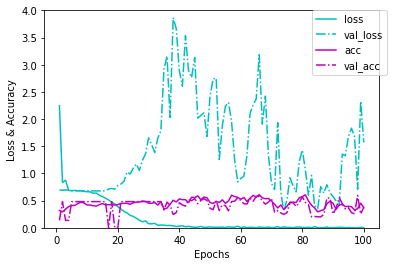

In [55]:
# 这是按照病人来的
loss = history5.history['loss']

acc = history5.history['accuracy']


val_loss = history5.history['val_loss']
#
val_acc = history5.history['val_accuracy']

epochs = range(1,len(loss) +1)
# plt.set_ylim([0,1])
plt.ylim([0, 4])
plt.plot(epochs, loss, 'c', label='loss')
plt.plot(epochs, val_loss, 'c-.', label='val_loss')

plt.plot(epochs, acc, 'm', label='acc')
plt.plot(epochs, val_acc, 'm-.', label='val_acc')

plt.legend(bbox_to_anchor=(0.8, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Epochs')
plt.ylabel('Loss & Accuracy')

# plt.savefig('/content/drive/My Drive/images/2dcnn/loss_acc13.png' ,dpi=800)
# 



# 打平结果成1List

In [56]:

def flatten(data):
  newlist = [item for items in data for item in items]
  for i in range(len(newlist)):
    if newlist[i] >= 0.5:
      newlist[i] = 1
    else:
      newlist[i] = 0
  return newlist



In [57]:
aaa = test_label2
bbb = model5.predict(test_data)

newlist = flatten(aaa)
newlist1 = flatten(bbb)

accuracy_score(newlist,newlist1)

0.7195833333333334

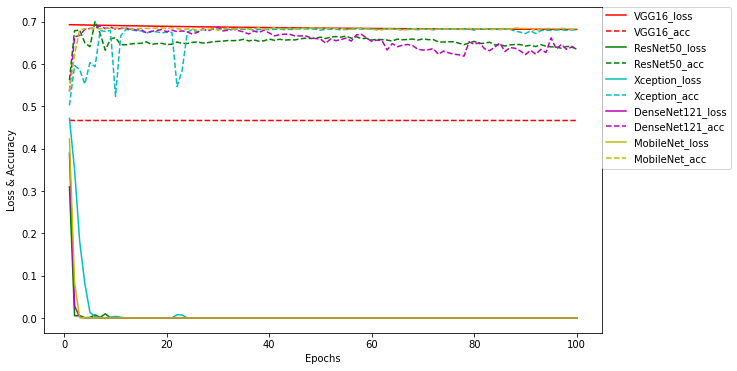

In [141]:


# mse = history.history['loss'] 
# mae = history.history['mae']
loss1 = history1.history['loss']
acc1 = history1.history['accuracy']
loss2 = history2.history['loss']
acc2 = history2.history['accuracy']
loss3 = history3.history['loss']
acc3 = history3.history['accuracy']
loss4 = history4.history['loss']
acc4 = history4.history['accuracy']
loss5 = history5.history['loss']
acc5 = history5.history['accuracy']

# model = ZF_Net()
# model1 = VGG16()
# model2 = ResNet50()
# model3 = Xception()
# model4 = DenseNet121()
# model5 = MobileNet()
# model6 = get_model9()

epochs = range(1,len(loss2) +1)
# plt.plot(epochs, mse, 'b', label='Proposed Net')
plt.figure(figsize=(10,6))
# plt.plot(epochs, mae, 'b--', label='mae')
plt.plot(epochs, loss1, 'r', label='VGG16_loss')
plt.plot(epochs, acc1, 'r--', label='VGG16_acc')
plt.plot(epochs, loss2, 'g', label='ResNet50_loss')
plt.plot(epochs, acc2, 'g--', label='ResNet50_acc')
plt.plot(epochs, loss3, 'c', label='Xception_loss')
plt.plot(epochs, acc3, 'c--', label='Xception_acc')
plt.plot(epochs, loss4, 'm', label='DenseNet121_loss')
plt.plot(epochs, acc4, 'm--', label='DenseNet121_acc')
plt.plot(epochs, loss5, 'y', label='MobileNet_loss')
plt.plot(epochs, acc5, 'y--', label='MobileNet_acc')


plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Epochs')
plt.ylabel('Loss & Accuracy')
# plt.show() 
plt.savefig('/content/drive/My Drive/images/2dcnn/loss_acc_multi1.png' ,dpi=800,bbox_inches='tight')

In [ ]:
# 这是按照病人来的
loss = history5.history['loss']
y1_loss = history5.history['y1_loss']
y2_loss = history5.history['y2_loss']
y3_loss = history5.history['y3_loss']
y4_loss = history5.history['y4_loss']
y1_acc = history5.history['y1_accuracy']
y2_acc = history5.history['y2_accuracy']
y3_acc = history5.history['y3_accuracy']
y4_acc = history5.history['y4_accuracy']

val_loss = history5.history['val_loss']
val_y1_loss = history5.history['val_y1_loss']
val_y2_loss = history5.history['val_y2_loss']
val_y3_loss = history5.history['val_y3_loss']
val_y4_loss = history5.history['val_y4_loss']
val_y1_acc = history5.history['val_y1_accuracy']
val_y2_acc = history5.history['val_y2_accuracy']
val_y3_acc = history5.history['val_y3_accuracy']
val_y4_acc = history5.history['val_y4_accuracy']




# y1 loss&acc 

Text(0, 0.5, 'Loss & MAE')

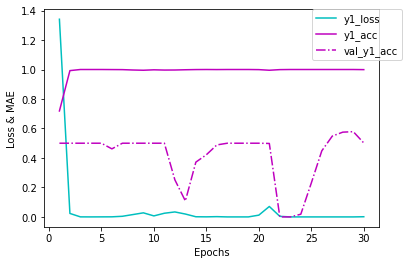

In [ ]:
epochs = range(1,len(loss) +1)
plt.plot(epochs, y1_loss, 'c', label='y1_loss')
# plt.plot(epochs, val_y1_loss, 'c-.', label='val_y1_loss')

plt.plot(epochs, y1_acc, 'm', label='y1_acc')
plt.plot(epochs, val_y1_acc, 'm-.', label='val_y1_acc')

plt.legend(bbox_to_anchor=(0.8, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Epochs')
plt.ylabel('Loss & MAE')

# plt.savefig('/content/drive/My Drive/images/1dcnn/loss_mae_6.png' ,dpi=800)

Text(0, 0.5, 'Loss & MAE')

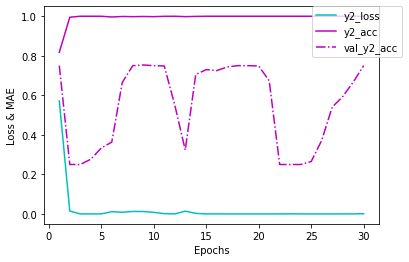

In [ ]:
epochs = range(1,len(loss) +1)
plt.plot(epochs, y2_loss, 'c', label='y2_loss')
# plt.plot(epochs, val_y2_loss, 'c-.', label='val_y2_loss')

plt.plot(epochs, y2_acc, 'm', label='y2_acc')
plt.plot(epochs, val_y2_acc, 'm-.', label='val_y2_acc')

plt.legend(bbox_to_anchor=(0.8, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Epochs')
plt.ylabel('Loss & MAE')

# plt.savefig('/content/drive/My Drive/images/1dcnn/loss_mae_6.png' ,dpi=800)

# 预测值

In [ ]:

# 这部分就是各个模型在测试集的表现
newx = test_data 

m1 = model5.predict(newx) 



In [ ]:
print(test_data.shape)
print(m1[0].shape)

(600, 116, 116, 3)
(600, 3)


In [ ]:
tm = model.predict(test_data)   #预测测试集label

num = 600
for i in range(num): #将测试集预测label转化为0,1
  for j in range(4):
    if tm[i,j]>= 0.5:
      tm[i,j] = 1
    if tm[i,j]<0.5:
      tm[i,j] = 0
print(tm[145:155])

Test_label = np.zeros((num,4))  #将测试集真实label放进array
for i in range(num):
  for j in range(4):
    Test_label[i,j] = test_label[i,j]


400


In [ ]:
# m = model2.predict(train_data[200:201])
tttt = range(399,401)
print("真实值",test_label3[tttt])
print("预测值",m1[399:401])
# print(m5[tttt])
# print(m)

真实值 [[[0. 0. 1.]
  [0. 0. 1.]
  [1. 0. 0.]
  [0. 0. 1.]]

 [[0. 0. 1.]
  [0. 0. 1.]
  [1. 0. 0.]
  [0. 0. 1.]]]
预测值 [array([[3.8579339e-04, 9.2781022e-07, 9.9961334e-01],
       [3.4561712e-05, 1.5465646e-06, 9.9996388e-01],
       [3.1270716e-05, 1.1579079e-06, 9.9996758e-01],
       ...,
       [8.2266517e-24, 1.2326576e-20, 1.0000000e+00],
       [2.9576180e-24, 3.3099418e-21, 1.0000000e+00],
       [9.3821969e-25, 1.7702253e-21, 1.0000000e+00]], dtype=float32)]


In [ ]:
print(m1[0])

[34.000965 12.500832 41.97254 ]


In [ ]:
# r = r2_score(test_label, m/100, multioutput='raw_values')
r11 = r2_score(train_label, model5.predict(train_data), multioutput='raw_values')
r112 = r2_score(test_label3, model5.predict(test_data), multioutput='raw_values')
# r22 = r2_score(test_label, m2/100, multioutput='raw_values')
# r22 = r2_score(train_label, model2.predict(train_data), multioutput='raw_values')
# r33 = r2_score(train_label, model3.predict(train_data), multioutput='raw_values')
# r44 = r2_score(train_label, model4.predict(train_data), multioutput='raw_values')
# r55 = r2_score(train_label, model5.predict(train_data), multioutput='raw_values')
print("training r2",r11)
print("testing r2",r112)
# print(r22)
# print(r33)
# print(r44)
# print(r55)
# print(r2)

training r2 [-0.69327004 -3.52927516 -0.12330049]
testing r2 [ -2.44632827  -6.98504443 -19.79336027]


In [ ]:
def calculate_mse(predict):   #对比三种视觉情况 每个model的mse  
  nums = 600 #测试集数量
  y_data_c1 = test_label3[:,0] 
  y_data_c2 = test_label3[:,1] 
  y_data_c3 = test_label3[:,2] 
  y_predict1_c1 = predict[:,0]/100
  y_predict1_c2 = predict[:,1]/100
  y_predict1_c3 = predict[:,2]/100
  tmp1 = 0
  tmp2 = 0
  tmp3 = 0
  for i in range(nums):
    tmp1 = tmp1 + (y_data_c1[i]- y_predict1_c1[i])**2
    tmp2 = tmp2 + (y_data_c2[i]- y_predict1_c2[i])**2
    tmp3 = tmp3 + (y_data_c3[i]- y_predict1_c3[i])**2
  c1 = tmp1/nums
  c2 = tmp2/nums
  c3 = tmp3/nums
  # c1 = K.mean(K.square( y_data_c1- y_predict1_c1), axis=-1)
  # c2 = K.mean(K.square( y_data_c2- y_predict1_c2), axis=-1)
  # c3 = K.mean(K.square( y_data_c3- y_predict1_c3), axis=-1)
  return c1, c2, c3 
# Model = calculate_mse(m)
Model1 = calculate_mse(m1)
# Model2 = calculate_mse(m2)
# Model3 = calculate_mse(m3)
# Model4 = calculate_mse(m4)
# Model5 = calculate_mse(m5)

# print(Model)
print(Model1)
# print(Model2)
# print(Model3)
# print(Model4)
# print(Model5)

(0.011927469107381353, 0.029517156211491848, 0.018487020060958682)


In [ ]:
# r = r2_score(test_label, m/100, multioutput='raw_values')
r1 = r2_score(test_label3, m1/100, multioutput='raw_values')
# r2 = r2_score(test_label, m2/100, multioutput='raw_values')
# r3 = r2_score(test_label, m3/100, multioutput='raw_values')
# r4 = r2_score(test_label, m4/100, multioutput='raw_values')
# r5 = r2_score(test_label, m5/100, multioutput='raw_values')

# print(r)
print(r1)
# print(r2)
# print(r3)
# print(r4)
# print(r5)

[-6.34331767e-03 -7.03737899e-01 -7.95271713e+00]


# 3个label

# 测试集

In [ ]:
c1 = test_label[:,0] * 100# 对测试集的真实数值c1进行大小排列  
c2 = test_label[:,1] * 100# 对测试集的真实数值c2进行大小排列
c3 = test_label[:,2] * 100# 对测试集的真实数值c3进行大小排列

# print(y_data_c1)

index1 = np.argsort(c1) #c1提取出按照从小到大的对应index
index2 = np.argsort(c2)   #c2提取出按照从小到大的对应index
index3 = np.argsort(c3)  #c3提取出按照从小到大的对应index 

c1.sort()
c2.sort()
c3.sort()
# print(index1)

yc1 = []
yc2 = []
yc3 = []
y1c1 = []
y1c2 = []
y1c3 = []
y2c1 = []
y2c2 = []
y2c3 = []
y3c1 = []
y3c2 = []
y3c3 = []
y4c1 = []
y4c2 = []
y4c3 = []
y5c1 = []
y5c2 = []
y5c3 = []

for i in range(600):
  # yc1.append([m[i,0],index1[i]])
  # yc2.append([m[i,1],index2[i]])
  # yc3.append([m[i,2],index3[i]])
  y1c1.append([m1[i,0],index1[i]])
  y1c2.append([m1[i,1],index2[i]])
  y1c3.append([m1[i,2],index3[i]])
  # y2c1.append([m2[i,0],index1[i]])
  # y2c2.append([m2[i,1],index2[i]])
  # y2c3.append([m2[i,2],index3[i]])
  # y3c1.append([m3[i,0],index1[i]])
  # y3c2.append([m3[i,1],index2[i]])
  # y3c3.append([m3[i,2],index3[i]])
  # y4c1.append([m4[i,0],index1[i]])
  # y4c2.append([m4[i,1],index2[i]])
  # y4c3.append([m4[i,2],index3[i]])
  # y5c1.append([m5[i,0],index1[i]])
  # y5c2.append([m5[i,1],index2[i]])
  # y5c3.append([m5[i,2],index3[i]])

# yc1.sort(key = lambda x: x[1]) 
# yc2.sort(key = lambda x: x[1])
# yc3.sort(key = lambda x: x[1])
y1c1.sort(key = lambda x: x[1]) 
y1c2.sort(key = lambda x: x[1])
y1c3.sort(key = lambda x: x[1])
# y2c1.sort(key = lambda x: x[1]) 
# y2c2.sort(key = lambda x: x[1])
# y2c3.sort(key = lambda x: x[1])
# y3c1.sort(key = lambda x: x[1]) 
# y3c2.sort(key = lambda x: x[1])
# y3c3.sort(key = lambda x: x[1])
# y4c1.sort(key = lambda x: x[1]) 
# y4c2.sort(key = lambda x: x[1])
# y4c3.sort(key = lambda x: x[1])
# y5c1.sort(key = lambda x: x[1]) 
# y5c2.sort(key = lambda x: x[1])
# y5c3.sort(key = lambda x: x[1])  





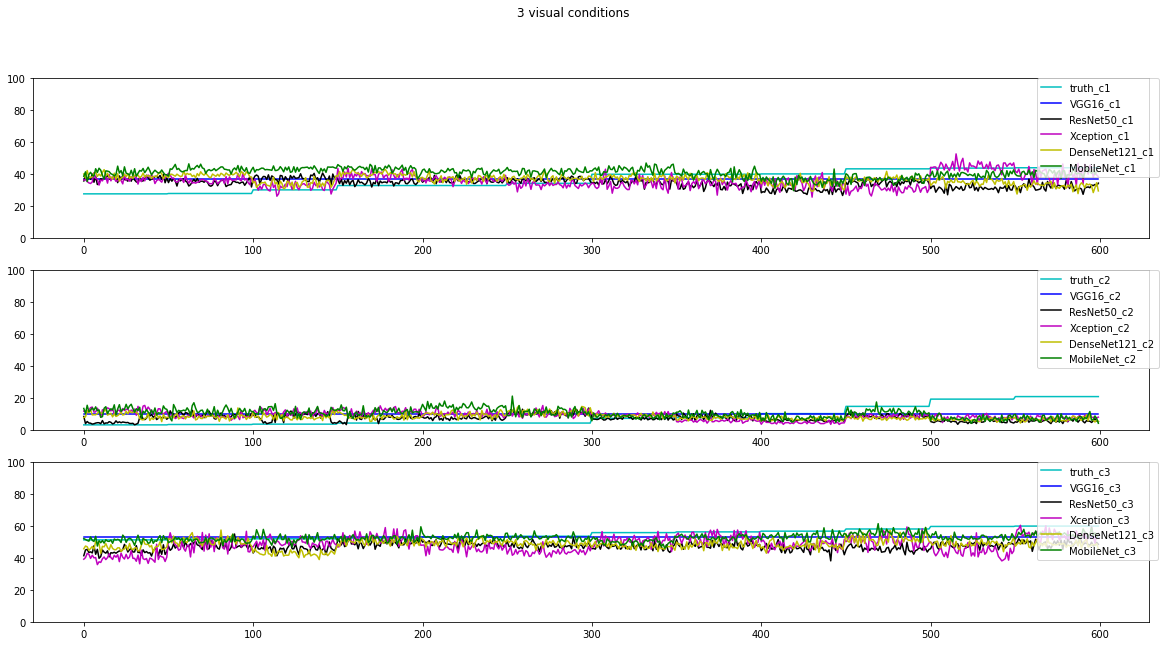

In [ ]:
samples = 600
x_data = range(samples)
# y_data_c1 = test_label[:,0]  
# y_data_c2 = test_label[:,1]
# y_data_c3 = test_label[:,2]

# yc1 = np.array(yc1)
# yc2 = np.array(yc2)
# yc3 = np.array(yc3)
y1c1 = np.array(y1c1)
y1c2 = np.array(y1c2)
y1c3 = np.array(y1c3)
# y2c1 = np.array(y2c1)
# y2c2 = np.array(y2c2)
# y2c3 = np.array(y2c3)
# y3c1 = np.array(y3c1)
# y3c2 = np.array(y3c2)
# y3c3 = np.array(y3c3)
# y4c1 = np.array(y4c1)
# y4c2 = np.array(y4c2)
# y4c3 = np.array(y4c3)
# y5c1 = np.array(y5c1)
# y5c2 = np.array(y5c2)
# y5c3 = np.array(y5c3)

# y_predict_c1 = m[:,0]
# y_predict_c2 = m[:,1]
# y_predict_c3 = m[:,2]
# y_predict1_c1 = m1[:,0]
# y_predict1_c2 = m1[:,1]
# y_predict1_c3 = m1[:,2]
# y_predict2_c1 = m2[:,0]
# y_predict2_c2 = m2[:,1]
# y_predict2_c3 = m2[:,2]
# y_predict3_c1 = m3[:,0]
# y_predict3_c2 = m3[:,1]
# y_predict3_c3 = m3[:,2]
# y_predict4_c1 = m4[:,0]
# y_predict4_c2 = m4[:,1]
# y_predict4_c3 = m4[:,2]
# y_predict5_c1 = m5[:,0]
# y_predict5_c2 = m5[:,1]
# y_predict5_c3 = m5[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(20,10))
fig.suptitle('3 visual conditions')

predict_c1.set_ylim([0,100])
predict_c2.set_ylim([0,100])
predict_c3.set_ylim([0,100])

predict_c1.plot(x_data, c1[:samples] , 'c', label='truth_c1')
predict_c2.plot(x_data, c2[:samples] , 'c', label='truth_c2')
predict_c3.plot(x_data, c3[:samples] , 'c', label='truth_c3')
# predict_c1.plot(x_data, yc1[:samples,0] , 'r', label='My proposed_c1')
# predict_c2.plot(x_data, yc2[:samples,0], 'r', label='My proposed_c2')
# predict_c3.plot(x_data, yc3[:samples,0], 'r', label='My proposed_c3')
predict_c1.plot(x_data, y1c1[:samples,0] , 'b', label='VGG16_c1')
predict_c2.plot(x_data, y1c2[:samples,0] , 'b', label='VGG16_c2')
predict_c3.plot(x_data, y1c3[:samples,0] , 'b', label='VGG16_c3')
# predict_c1.plot(x_data, y2c1[:samples,0] , 'k', label='ResNet50_c1')
# predict_c2.plot(x_data, y2c2[:samples,0] , 'k', label='ResNet50_c2')
# predict_c3.plot(x_data, y2c3[:samples,0] , 'k', label='ResNet50_c3')
# predict_c1.plot(x_data, y3c1[:samples,0] , 'm', label='Xception_c1')
# predict_c2.plot(x_data, y3c2[:samples,0] , 'm', label='Xception_c2')
# predict_c3.plot(x_data, y3c3[:samples,0] , 'm', label='Xception_c3')
# predict_c1.plot(x_data, y4c1[:samples,0] , 'y', label='DenseNet121_c1')
# predict_c2.plot(x_data, y4c2[:samples,0] , 'y', label='DenseNet121_c2')
# predict_c3.plot(x_data, y4c3[:samples,0] , 'y', label='DenseNet121_c3')
# predict_c1.plot(x_data, y5c1[:samples,0] , 'g', label='MobileNet_c1')
# predict_c2.plot(x_data, y5c2[:samples,0] , 'g', label='MobileNet_c2')
# predict_c3.plot(x_data, y5c3[:samples,0] , 'g', label='MobileNet_c3')


predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)


# plt.plot(x_data, y_data_c1 , 'c', label='c1')
# plt.plot(x_data, y_data_c2 , 'r', label='c2')
# plt.plot(x_data, y_data_c3 , 'b', label='c3')
# plt.plot(x_data, y_predict1_c1 , 'c--', label='predict1_c1')
# plt.plot(x_data, y_predict1_c2 , 'r--', label='predict1_c2')
# plt.plot(x_data, y_predict1_c3 , 'b--', label='predict1_c3')
# plt.plot(x_data, y_predict2_c1 , 'c:', label='predict2_c1')
# plt.plot(x_data, y_predict2_c2 , 'r:', label='predict2_c2')
# plt.plot(x_data, y_predict2_c3 , 'b:', label='predict2_c3')
# plt.plot(x_data, y_predict3_c1 , 'c-.', label='predict3_c1')
# plt.plot(x_data, y_predict3_c2 , 'r-.', label='predict3_c2')
# plt.plot(x_data, y_predict3_c3 , 'b-.', label='predict3_c3')

# plt.legend(loc="upper right",fontsize = 'small',bbox_to_anchor=(0.5, -0.05))

# plt.title('loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show() 
# fig.savefig('/content/drive/My Drive/images/2dcnn/prediction.png' ,dpi=800)

In [ ]:
def calculate_mse(predict):   #对比三种视觉情况 每个model的mse  
  nums = 600 #测试集数量
  y_data_c1 = test_label[:,0] 
  y_data_c2 = test_label[:,1] 
  y_data_c3 = test_label[:,2] 
  y_predict1_c1 = predict[:,0]/100
  y_predict1_c2 = predict[:,1]/100
  y_predict1_c3 = predict[:,2]/100
  tmp1 = 0
  tmp2 = 0
  tmp3 = 0
  for i in range(nums):
    tmp1 = tmp1 + (y_data_c1[i]- y_predict1_c1[i])**2
    tmp2 = tmp2 + (y_data_c2[i]- y_predict1_c2[i])**2
    tmp3 = tmp3 + (y_data_c3[i]- y_predict1_c3[i])**2
  c1 = tmp1/nums
  c2 = tmp2/nums
  c3 = tmp3/nums
  # c1 = K.mean(K.square( y_data_c1- y_predict1_c1), axis=-1)
  # c2 = K.mean(K.square( y_data_c2- y_predict1_c2), axis=-1)
  # c3 = K.mean(K.square( y_data_c3- y_predict1_c3), axis=-1)
  return c1, c2, c3 
# Model = calculate_mse(m)
Model1 = calculate_mse(m1)
# Model2 = calculate_mse(m2)
# Model3 = calculate_mse(m3)
# Model4 = calculate_mse(m4)
# Model5 = calculate_mse(m5)

# print(Model)
print(Model1)
# print(Model2)
# print(Model3)
# print(Model4)
# print(Model5)

In [ ]:
# r = r2_score(test_label, m/100, multioutput='raw_values')
r1 = r2_score(test_label, m1/100, multioutput='raw_values')
# r2 = r2_score(test_label, m2/100, multioutput='raw_values')
# r3 = r2_score(test_label, m3/100, multioutput='raw_values')
# r4 = r2_score(test_label, m4/100, multioutput='raw_values')
# r5 = r2_score(test_label, m5/100, multioutput='raw_values')

# print(r)
print(r1)
# print(r2)
# print(r3)
# print(r4)
# print(r5)

# 训练集

In [ ]:
c1 = train_label[:,0] * 100 
c2 = train_label[:,1] * 100
c3 = train_label[:,2] * 100

m1 = model1.predict(train_data)
m2 = model2.predict(train_data)
m3 = model3.predict(train_data)
m4 = model4.predict(train_data)
m5 = model5.predict(train_data)

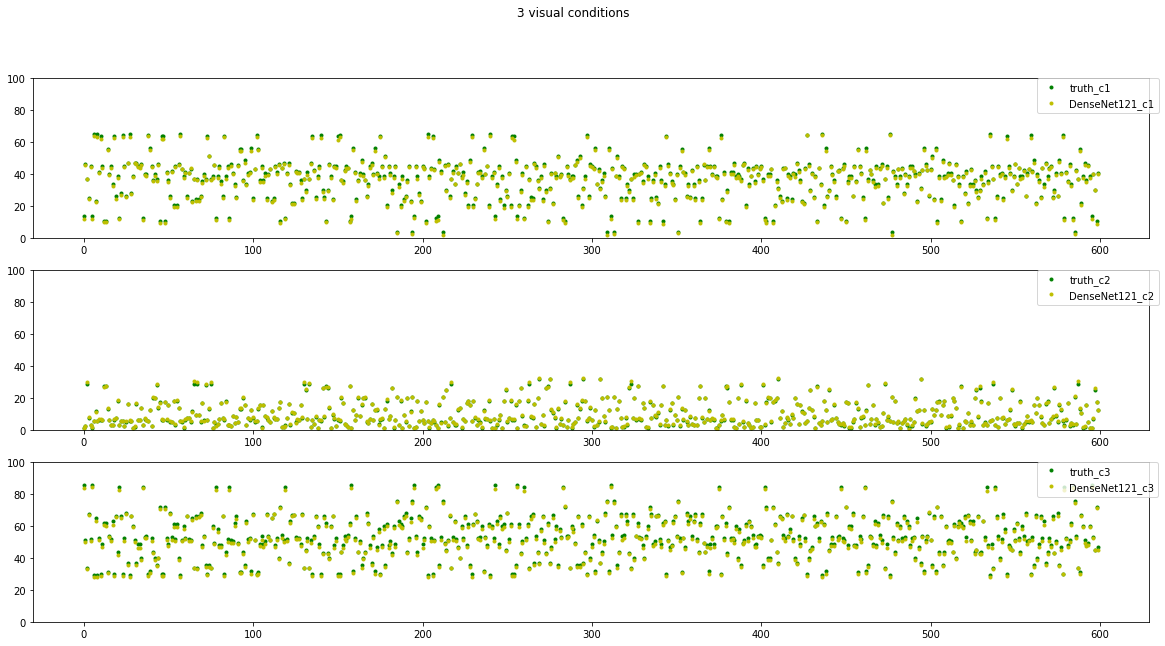

In [ ]:
samples = 600
x_data = range(samples)

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(20,10))
fig.suptitle('3 visual conditions')

predict_c1.set_ylim([0,100])
predict_c2.set_ylim([0,100])
predict_c3.set_ylim([0,100])

predict_c1.plot(x_data, c1[:samples] , 'g.', label='truth_c1')
predict_c2.plot(x_data, c2[:samples] , 'g.', label='truth_c2')
predict_c3.plot(x_data, c3[:samples] , 'g.', label='truth_c3')
# predict_c1.plot(x_data, yc1[:samples,0] , 'r', label='My proposed_c1')
# predict_c2.plot(x_data, yc2[:samples,0], 'r', label='My proposed_c2')
# predict_c3.plot(x_data, yc3[:samples,0], 'r', label='My proposed_c3')
# predict_c1.plot(x_data, m1[:samples,0]*100 , 'b.', label='VGG16_c1')
# predict_c2.plot(x_data, m1[:samples,1]*100 , 'b.', label='VGG16_c2')
# predict_c3.plot(x_data, m1[:samples,2]*100 , 'b.', label='VGG16_c3')
# predict_c1.plot(x_data, m2[:samples,0]*100 , 'k.',label='ResNet50_c1')
# predict_c2.plot(x_data, m2[:samples,1]*100 , 'k.', label='ResNet50_c2')
# predict_c3.plot(x_data, m2[:samples,2]*100 , 'k.', label='ResNet50_c3')
# predict_c1.plot(x_data, m3[:samples,0]*100 , 'm.', label='Xception_c1')
# predict_c2.plot(x_data, m3[:samples,1]*100 , 'm.', label='Xception_c2')
# predict_c3.plot(x_data, m3[:samples,2]*100 , 'm.', label='Xception_c3')
predict_c1.plot(x_data, m4[:samples,0]*100 , 'y.', label='DenseNet121_c1')
predict_c2.plot(x_data, m4[:samples,1]*100 , 'y.', label='DenseNet121_c2')
predict_c3.plot(x_data, m4[:samples,2]*100 , 'y.', label='DenseNet121_c3')
# predict_c1.plot(x_data, m5[:samples,0]*100 , 'c.', label='MobileNet_c1')
# predict_c2.plot(x_data, m5[:samples,1]*100 , 'c.', label='MobileNet_c2')
# predict_c3.plot(x_data, m5[:samples,2]*100 , 'c.', label='MobileNet_c3')


predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
fig.savefig('/content/drive/My Drive/images/2dcnn/train3.png' ,dpi=800)

In [ ]:
print(m1.shape)

(3000, 3)


In [ ]:
c1 = train_label[:,0] * 100# 对测试集的真实数值c1进行大小排列  
c2 = train_label[:,1] * 100# 对测试集的真实数值c2进行大小排列
c3 = train_label[:,2] * 100# 对测试集的真实数值c3进行大小排列

# print(y_data_c1)

index1 = np.argsort(c1) #c1提取出按照从小到大的对应index
index2 = np.argsort(c2)   #c2提取出按照从小到大的对应index
index3 = np.argsort(c3)  #c3提取出按照从小到大的对应index 

c1.sort()
c2.sort()
c3.sort()
# print(index1)

yc1 = []
yc2 = []
yc3 = []
y1c1 = []
y1c2 = []
y1c3 = []
y2c1 = []
y2c2 = []
y2c3 = []
y3c1 = []
y3c2 = []
y3c3 = []
y4c1 = []
y4c2 = []
y4c3 = []
y5c1 = []
y5c2 = []
y5c3 = []

m1 = model1.predict(train_data)
m2 = model2.predict(train_data)
m3 = model3.predict(train_data)
m4 = model4.predict(train_data)
m5 = model5.predict(train_data)



for i in range(3000):
  # yc1.append([m[i,0],index1[i]])
  # yc2.append([m[i,1],index2[i]])
  # yc3.append([m[i,2],index3[i]])
  y1c1.append([m1[i,0],index1[i]])
  y1c2.append([m1[i,1],index2[i]])
  y1c3.append([m1[i,2],index3[i]])
  y2c1.append([m2[i,0],index1[i]])
  y2c2.append([m2[i,1],index2[i]])
  y2c3.append([m2[i,2],index3[i]])
  y3c1.append([m3[i,0],index1[i]])
  y3c2.append([m3[i,1],index2[i]])
  y3c3.append([m3[i,2],index3[i]])
  y4c1.append([m4[i,0],index1[i]])
  y4c2.append([m4[i,1],index2[i]])
  y4c3.append([m4[i,2],index3[i]])
  y5c1.append([m5[i,0],index1[i]])
  y5c2.append([m5[i,1],index2[i]])
  y5c3.append([m5[i,2],index3[i]])

# yc1.sort(key = lambda x: x[1]) 
# yc2.sort(key = lambda x: x[1])
# yc3.sort(key = lambda x: x[1])
y1c1.sort(key = lambda x: x[1]) 
y1c2.sort(key = lambda x: x[1])
y1c3.sort(key = lambda x: x[1])
y2c1.sort(key = lambda x: x[1]) 
y2c2.sort(key = lambda x: x[1])
y2c3.sort(key = lambda x: x[1])
y3c1.sort(key = lambda x: x[1]) 
y3c2.sort(key = lambda x: x[1])
y3c3.sort(key = lambda x: x[1])
y4c1.sort(key = lambda x: x[1]) 
y4c2.sort(key = lambda x: x[1])
y4c3.sort(key = lambda x: x[1])
y5c1.sort(key = lambda x: x[1]) 
y5c2.sort(key = lambda x: x[1])
y5c3.sort(key = lambda x: x[1])  





In [ ]:
print(y5c1[0])

[0.11904776 0.        ]


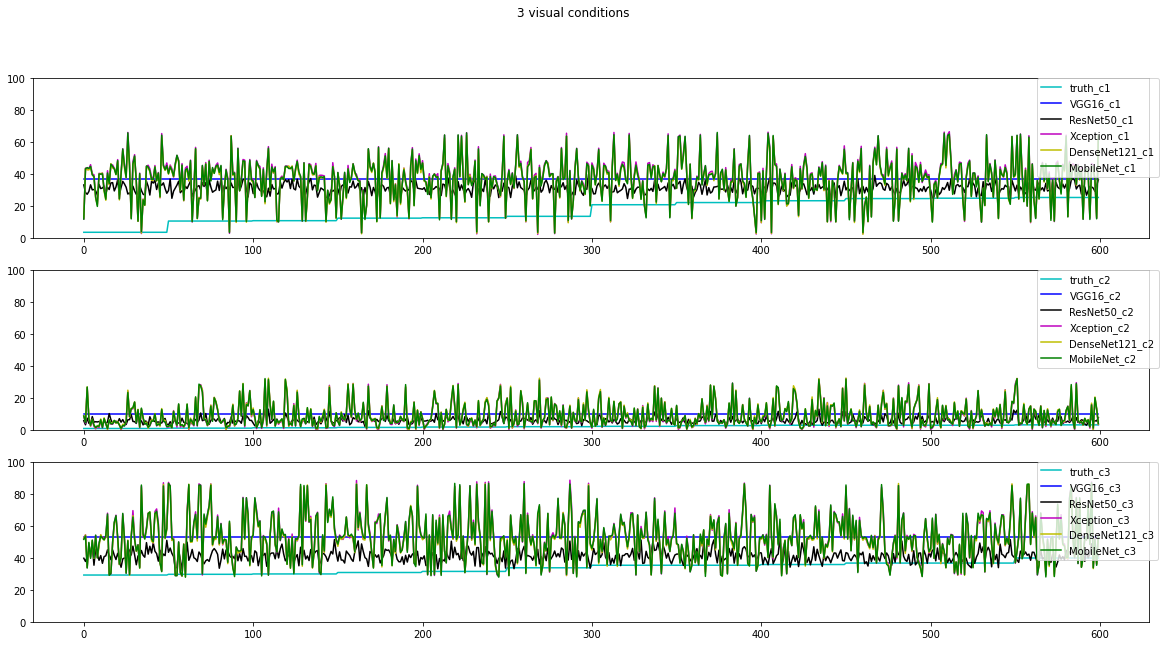

In [ ]:
samples = 600
x_data = range(samples)
# y_data_c1 = test_label[:,0]  
# y_data_c2 = test_label[:,1]
# y_data_c3 = test_label[:,2]

# yc1 = np.array(yc1)
# yc2 = np.array(yc2)
# yc3 = np.array(yc3)
y1c1 = np.array(y1c1)
y1c2 = np.array(y1c2)
y1c3 = np.array(y1c3)
y2c1 = np.array(y2c1)
y2c2 = np.array(y2c2)
y2c3 = np.array(y2c3)
y3c1 = np.array(y3c1)
y3c2 = np.array(y3c2)
y3c3 = np.array(y3c3)
y4c1 = np.array(y4c1)
y4c2 = np.array(y4c2)
y4c3 = np.array(y4c3)
y5c1 = np.array(y5c1)
y5c2 = np.array(y5c2)
y5c3 = np.array(y5c3)

# y_predict_c1 = m[:,0]
# y_predict_c2 = m[:,1]
# y_predict_c3 = m[:,2]
# y_predict1_c1 = m1[:,0]
# y_predict1_c2 = m1[:,1]
# y_predict1_c3 = m1[:,2]
# y_predict2_c1 = m2[:,0]
# y_predict2_c2 = m2[:,1]
# y_predict2_c3 = m2[:,2]
# y_predict3_c1 = m3[:,0]
# y_predict3_c2 = m3[:,1]
# y_predict3_c3 = m3[:,2]
# y_predict4_c1 = m4[:,0]
# y_predict4_c2 = m4[:,1]
# y_predict4_c3 = m4[:,2]
# y_predict5_c1 = m5[:,0]
# y_predict5_c2 = m5[:,1]
# y_predict5_c3 = m5[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(20,10))
fig.suptitle('3 visual conditions')

predict_c1.set_ylim([0,100])
predict_c2.set_ylim([0,100])
predict_c3.set_ylim([0,100])

predict_c1.plot(x_data, c1[:samples] , 'c', label='truth_c1')
predict_c2.plot(x_data, c2[:samples] , 'c', label='truth_c2')
predict_c3.plot(x_data, c3[:samples] , 'c', label='truth_c3')
# predict_c1.plot(x_data, yc1[:samples,0] , 'r', label='My proposed_c1')
# predict_c2.plot(x_data, yc2[:samples,0], 'r', label='My proposed_c2')
# predict_c3.plot(x_data, yc3[:samples,0], 'r', label='My proposed_c3')
predict_c1.plot(x_data, y1c1[:samples,0]*100 , 'b', label='VGG16_c1')
predict_c2.plot(x_data, y1c2[:samples,0]*100 , 'b', label='VGG16_c2')
predict_c3.plot(x_data, y1c3[:samples,0]*100 , 'b', label='VGG16_c3')
predict_c1.plot(x_data, y2c1[:samples,0]*100 , 'k', label='ResNet50_c1')
predict_c2.plot(x_data, y2c2[:samples,0]*100 , 'k', label='ResNet50_c2')
predict_c3.plot(x_data, y2c3[:samples,0]*100 , 'k', label='ResNet50_c3')
predict_c1.plot(x_data, y3c1[:samples,0]*100 , 'm', label='Xception_c1')
predict_c2.plot(x_data, y3c2[:samples,0]*100 , 'm', label='Xception_c2')
predict_c3.plot(x_data, y3c3[:samples,0]*100 , 'm', label='Xception_c3')
predict_c1.plot(x_data, y4c1[:samples,0]*100 , 'y', label='DenseNet121_c1')
predict_c2.plot(x_data, y4c2[:samples,0]*100 , 'y', label='DenseNet121_c2')
predict_c3.plot(x_data, y4c3[:samples,0]*100 , 'y', label='DenseNet121_c3')
predict_c1.plot(x_data, y5c1[:samples,0]*100 , 'g', label='MobileNet_c1')
predict_c2.plot(x_data, y5c2[:samples,0]*100 , 'g', label='MobileNet_c2')
predict_c3.plot(x_data, y5c3[:samples,0]*100 , 'g', label='MobileNet_c3')


predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)


# plt.plot(x_data, y_data_c1 , 'c', label='c1')
# plt.plot(x_data, y_data_c2 , 'r', label='c2')
# plt.plot(x_data, y_data_c3 , 'b', label='c3')
# plt.plot(x_data, y_predict1_c1 , 'c--', label='predict1_c1')
# plt.plot(x_data, y_predict1_c2 , 'r--', label='predict1_c2')
# plt.plot(x_data, y_predict1_c3 , 'b--', label='predict1_c3')
# plt.plot(x_data, y_predict2_c1 , 'c:', label='predict2_c1')
# plt.plot(x_data, y_predict2_c2 , 'r:', label='predict2_c2')
# plt.plot(x_data, y_predict2_c3 , 'b:', label='predict2_c3')
# plt.plot(x_data, y_predict3_c1 , 'c-.', label='predict3_c1')
# plt.plot(x_data, y_predict3_c2 , 'r-.', label='predict3_c2')
# plt.plot(x_data, y_predict3_c3 , 'b-.', label='predict3_c3')

# plt.legend(loc="upper right",fontsize = 'small',bbox_to_anchor=(0.5, -0.05))

# plt.title('loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show() 
# fig.savefig('/content/drive/My Drive/33333333_wo.png' ,dpi=800)

# 2个label

In [ ]:
c1 = test_label[:,0] * 100 # 对测试集的真实数值c1进行大小排列  
c2 = test_label[:,1] * 100# 对测试集的真实数值c2进行大小排列
# c3 = test_label[:,2] # 对测试集的真实数值c3进行大小排列

# print(y_data_c1)

index1 = np.argsort(c1) #c1提取出按照从小到大的对应index
index2 = np.argsort(c2)   #c2提取出按照从小到大的对应index
# index3 = np.argsort(c3)  #c3提取出按照从小到大的对应index 

c1.sort()
c2.sort()
# c3.sort()
# print(index1)

yc1 = []
yc2 = []
# yc3 = []
y1c1 = []
y1c2 = []
# y1c3 = []
y2c1 = []
y2c2 = []
# y2c3 = []
y3c1 = []
y3c2 = []
# y3c3 = []
y4c1 = []
y4c2 = []
# y4c3 = []
y5c1 = []
y5c2 = []
# y5c3 = []

for i in range(900):
  yc1.append([m[i,0],index1[i]])
  yc2.append([m[i,1],index2[i]])
  # yc3.append([m[i,2],index3[i]])
  y1c1.append([m1[i,0],index1[i]])
  y1c2.append([m1[i,1],index2[i]])
  # y1c3.append([m1[i,2],index3[i]])
  y2c1.append([m2[i,0],index1[i]])
  y2c2.append([m2[i,1],index2[i]])
  # y2c3.append([m2[i,2],index3[i]])
  y3c1.append([m3[i,0],index1[i]])
  y3c2.append([m3[i,1],index2[i]])
  # y3c3.append([m3[i,2],index3[i]])
  y4c1.append([m4[i,0],index1[i]])
  y4c2.append([m4[i,1],index2[i]])
  # y4c3.append([m4[i,2],index3[i]])
  y5c1.append([m5[i,0],index1[i]])
  y5c2.append([m5[i,1],index2[i]])
  # y5c3.append([m5[i,2],index3[i]])

yc1.sort(key = lambda x: x[1]) 
yc2.sort(key = lambda x: x[1])
# yc3.sort(key = lambda x: x[1])
y1c1.sort(key = lambda x: x[1]) 
y1c2.sort(key = lambda x: x[1])
# y1c3.sort(key = lambda x: x[1])
y2c1.sort(key = lambda x: x[1]) 
y2c2.sort(key = lambda x: x[1])
# y2c3.sort(key = lambda x: x[1])
y3c1.sort(key = lambda x: x[1]) 
y3c2.sort(key = lambda x: x[1])
# y3c3.sort(key = lambda x: x[1])
y4c1.sort(key = lambda x: x[1]) 
y4c2.sort(key = lambda x: x[1])
# y4c3.sort(key = lambda x: x[1])
y5c1.sort(key = lambda x: x[1]) 
y5c2.sort(key = lambda x: x[1])
# y5c3.sort(key = lambda x: x[1])  





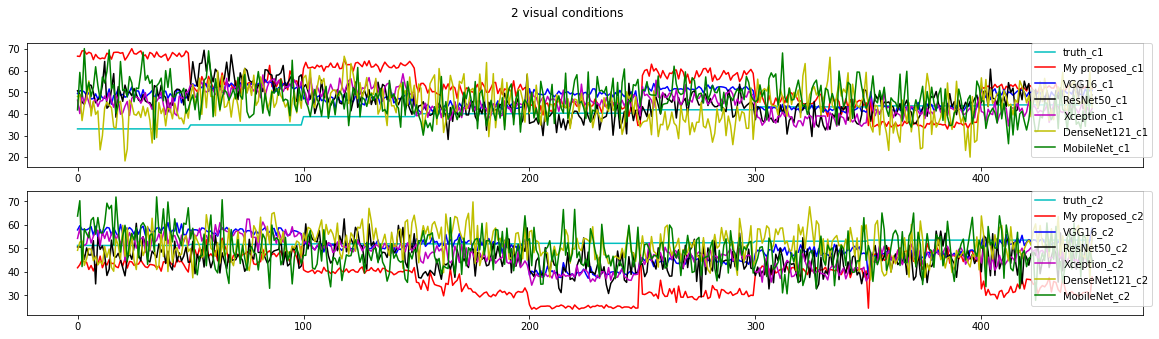

In [ ]:
samples = 450
x_data = range(samples)
# y_data_c1 = test_label[:,0]  
# y_data_c2 = test_label[:,1]
# y_data_c3 = test_label[:,2]

yc1 = np.array(yc1)
yc2 = np.array(yc2)
# yc3 = np.array(yc3)
y1c1 = np.array(y1c1)
y1c2 = np.array(y1c2)
# y1c3 = np.array(y1c3)
y2c1 = np.array(y2c1)
y2c2 = np.array(y2c2)
# y2c3 = np.array(y2c3)
y3c1 = np.array(y3c1)
y3c2 = np.array(y3c2)
# y3c3 = np.array(y3c3)
y4c1 = np.array(y4c1)
y4c2 = np.array(y4c2)
# y4c3 = np.array(y4c3)
y5c1 = np.array(y5c1)
y5c2 = np.array(y5c2)
# y5c3 = np.array(y5c3)

# y_predict_c1 = m[:,0]
# y_predict_c2 = m[:,1]
# y_predict_c3 = m[:,2]
# y_predict1_c1 = m1[:,0]
# y_predict1_c2 = m1[:,1]
# y_predict1_c3 = m1[:,2]
# y_predict2_c1 = m2[:,0]
# y_predict2_c2 = m2[:,1]
# y_predict2_c3 = m2[:,2]
# y_predict3_c1 = m3[:,0]
# y_predict3_c2 = m3[:,1]
# y_predict3_c3 = m3[:,2]
# y_predict4_c1 = m4[:,0]
# y_predict4_c2 = m4[:,1]
# y_predict4_c3 = m4[:,2]
# y_predict5_c1 = m5[:,0]
# y_predict5_c2 = m5[:,1]
# y_predict5_c3 = m5[:,2]

fig, (predict_c1, predict_c2) = plt.subplots(2,figsize=(20,5))
fig.suptitle('2 visual conditions')


predict_c1.plot(x_data, c1[:samples] , 'c', label='truth_c1')
predict_c2.plot(x_data, c2[:samples] , 'c', label='truth_c2')
# predict_c3.plot(x_data, c3 , 'c', label='truth_c3')
predict_c1.plot(x_data, yc1[:samples,0] , 'r', label='My proposed_c1')
predict_c2.plot(x_data, yc2[:samples,0], 'r', label='My proposed_c2')
# predict_c3.plot(x_data, yc3[:,0], 'r', label='predict_c3')
predict_c1.plot(x_data, y1c1[:samples,0] , 'b', label='VGG16_c1')
predict_c2.plot(x_data, y1c2[:samples,0] , 'b', label='VGG16_c2')
# predict_c3.plot(x_data, y1c3[:,0] , 'b', label='predict1_c3')
predict_c1.plot(x_data, y2c1[:samples,0] , 'k', label='ResNet50_c1')
predict_c2.plot(x_data, y2c2[:samples,0] , 'k', label='ResNet50_c2')
# predict_c3.plot(x_data, y2c3[:,0] , 'k', label='predict2_c3')
predict_c1.plot(x_data, y3c1[:samples,0] , 'm', label='Xception_c1')
predict_c2.plot(x_data, y3c2[:samples,0] , 'm', label='Xception_c2')
# predict_c3.plot(x_data, y3c3[:,0] , 'm', label='predict3_c3')
predict_c1.plot(x_data, y4c1[:samples,0] , 'y', label='DenseNet121_c1')
predict_c2.plot(x_data, y4c2[:samples,0] , 'y', label='DenseNet121_c2')
# predict_c3.plot(x_data, y4c3[:,0] , 'y', label='predict4_c3')
predict_c1.plot(x_data, y5c1[:samples,0] , 'g', label='MobileNet_c1')
predict_c2.plot(x_data, y5c2[:samples,0] , 'g', label='MobileNet_c2')
# predict_c3.plot(x_data, y5c3[:,0] , 'g', label='predict5_c3')


predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
# predict_c3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


# plt.plot(x_data, y_data_c1 , 'c', label='c1')
# plt.plot(x_data, y_data_c2 , 'r', label='c2')
# plt.plot(x_data, y_data_c3 , 'b', label='c3')
# plt.plot(x_data, y_predict1_c1 , 'c--', label='predict1_c1')
# plt.plot(x_data, y_predict1_c2 , 'r--', label='predict1_c2')
# plt.plot(x_data, y_predict1_c3 , 'b--', label='predict1_c3')
# plt.plot(x_data, y_predict2_c1 , 'c:', label='predict2_c1')
# plt.plot(x_data, y_predict2_c2 , 'r:', label='predict2_c2')
# plt.plot(x_data, y_predict2_c3 , 'b:', label='predict2_c3')
# plt.plot(x_data, y_predict3_c1 , 'c-.', label='predict3_c1')
# plt.plot(x_data, y_predict3_c2 , 'r-.', label='predict3_c2')
# plt.plot(x_data, y_predict3_c3 , 'b-.', label='predict3_c3')

# plt.legend(loc="upper right",fontsize = 'small',bbox_to_anchor=(0.5, -0.05))



# 
fig.savefig('/content/drive/My Drive/222222_wo.png' ,dpi=800)

In [ ]:
def calculate_mse(predict):   #对比三种视觉情况 每个model的mse  
  y_data_c1 = test_label[:,0] 
  y_data_c2 = test_label[:,1] 
  # y_data_c3 = test_label[:,2] 
  y_predict1_c1 = predict[:,0]/100
  y_predict1_c2 = predict[:,1]/100
  # y_predict1_c3 = predict[:,2]/100
  tmp1 = 0
  tmp2 = 0
  # tmp3 = 0
  for i in range(900):
    tmp1 = tmp1 + (y_data_c1[i]- y_predict1_c1[i])**2
    tmp2 = tmp2 + (y_data_c2[i]- y_predict1_c2[i])**2
    # tmp3 = tmp3 + (y_data_c3[i]- y_predict1_c3[i])**2
  c1 = tmp1/900
  c2 = tmp2/900
  # c3 = tmp3/900
  # c1 = K.mean(K.square( y_data_c1- y_predict1_c1), axis=-1)
  # c2 = K.mean(K.square( y_data_c2- y_predict1_c2), axis=-1)
  # c3 = K.mean(K.square( y_data_c3- y_predict1_c3), axis=-1)
  return c1, c2


In [ ]:
Model = calculate_mse(m)
Model1 = calculate_mse(m1)
Model2 = calculate_mse(m2)
Model3 = calculate_mse(m3)
Model4 = calculate_mse(m4)
Model5 = calculate_mse(m5)
print(Model)
print(Model1)
print(Model2)
print(Model3)
print(Model4)
print(Model5)

(0.029099316610645312, 0.04103815036646819)
(0.007828096840408076, 0.007808124957348473)
(0.008478164341184298, 0.01408359073363868)
(0.00642479640356437, 0.009987149061102315)
(0.008091170958400512, 0.00777622325138939)
(0.009062269871027151, 0.013253465635832922)


In [ ]:
r = r2_score(test_label, m/100, multioutput='raw_values')
r1 = r2_score(test_label, m1/100, multioutput='raw_values')
r2 = r2_score(test_label, m2/100, multioutput='raw_values')
r3 = r2_score(test_label, m3/100, multioutput='raw_values')
r4 = r2_score(test_label, m4/100, multioutput='raw_values')
r5 = r2_score(test_label, m5/100, multioutput='raw_values')

In [ ]:
print(r)
print(r1)
print(r2)
print(r3)
print(r4)
print(r5)

[-12.64043325 -18.23681433]
[-2.66945499 -2.66009308]
[-2.974177   -5.60174539]
[-2.0116517  -3.68152025]
[-2.79277214 -2.64513901]
[-3.24797905 -5.21262058]


# 以下不要动

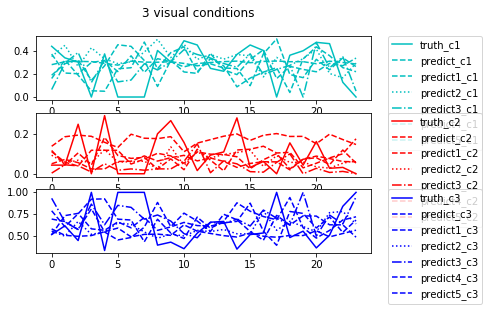

In [ ]:
x_data = range(24)
y_data_c1 = test_label[:,0]  
y_data_c2 = test_label[:,1]
y_data_c3 = test_label[:,2]

y_predict_c1 = m[:,0]
y_predict_c2 = m[:,1]
y_predict_c3 = m[:,2]
y_predict1_c1 = m1[:,0]
y_predict1_c2 = m1[:,1]
y_predict1_c3 = m1[:,2]
y_predict2_c1 = m2[:,0]
y_predict2_c2 = m2[:,1]
y_predict2_c3 = m2[:,2]
y_predict3_c1 = m3[:,0]
y_predict3_c2 = m3[:,1]
y_predict3_c3 = m3[:,2]
y_predict4_c1 = m4[:,0]
y_predict4_c2 = m4[:,1]
y_predict4_c3 = m4[:,2]
y_predict5_c1 = m5[:,0]
y_predict5_c2 = m5[:,1]
y_predict5_c3 = m5[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3)
fig.suptitle('3 visual conditions')


predict_c1.plot(x_data, y_data_c1 , 'c', label='truth_c1')
predict_c2.plot(x_data, y_data_c2 , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3 , 'b', label='truth_c3')
predict_c1.plot(x_data, y_predict_c1 , 'c--', label='predict_c1')
predict_c2.plot(x_data, y_predict_c2 , 'r--', label='predict_c2')
predict_c3.plot(x_data, y_predict_c3 , 'b--', label='predict_c3')
predict_c1.plot(x_data, y_predict1_c1 , 'c--', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2 , 'r--', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3 , 'b--', label='predict1_c3')
predict_c1.plot(x_data, y_predict2_c1 , 'c:', label='predict2_c1')
predict_c2.plot(x_data, y_predict2_c2 , 'r:', label='predict2_c2')
predict_c3.plot(x_data, y_predict2_c3 , 'b:', label='predict2_c3')
predict_c1.plot(x_data, y_predict3_c1 , 'c-.', label='predict3_c1')
predict_c2.plot(x_data, y_predict3_c2 , 'r-.', label='predict3_c2')
predict_c3.plot(x_data, y_predict3_c3 , 'b-.', label='predict3_c3')
predict_c1.plot(x_data, y_predict4_c1 , 'c--', label='predict4_c1')
predict_c2.plot(x_data, y_predict4_c2 , 'r--', label='predict4_c2')
predict_c3.plot(x_data, y_predict4_c3 , 'b--', label='predict4_c3')
predict_c1.plot(x_data, y_predict5_c1 , 'c--', label='predict5_c1')
predict_c2.plot(x_data, y_predict5_c2 , 'r--', label='predict5_c2')
predict_c3.plot(x_data, y_predict5_c3 , 'b--', label='predict5_c3')


predict_c1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


# plt.plot(x_data, y_data_c1 , 'c', label='c1')
# plt.plot(x_data, y_data_c2 , 'r', label='c2')
# plt.plot(x_data, y_data_c3 , 'b', label='c3')
# plt.plot(x_data, y_predict1_c1 , 'c--', label='predict1_c1')
# plt.plot(x_data, y_predict1_c2 , 'r--', label='predict1_c2')
# plt.plot(x_data, y_predict1_c3 , 'b--', label='predict1_c3')
# plt.plot(x_data, y_predict2_c1 , 'c:', label='predict2_c1')
# plt.plot(x_data, y_predict2_c2 , 'r:', label='predict2_c2')
# plt.plot(x_data, y_predict2_c3 , 'b:', label='predict2_c3')
# plt.plot(x_data, y_predict3_c1 , 'c-.', label='predict3_c1')
# plt.plot(x_data, y_predict3_c2 , 'r-.', label='predict3_c2')
# plt.plot(x_data, y_predict3_c3 , 'b-.', label='predict3_c3')

# plt.legend(loc="upper right",fontsize = 'small',bbox_to_anchor=(0.5, -0.05))

# plt.title('loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show() 

In [ ]:
x_data = range(20)
y_data_c1 = test_label[:,0]
y_data_c2 = test_label[:,1]
y_data_c3 = test_label[:,2]
y_predict1_c1 = m1[:,0]
y_predict1_c2 = m1[:,1]
y_predict1_c3 = m1[:,2]
y_predict2_c1 = m2[:,0]
y_predict2_c2 = m2[:,1]
y_predict2_c3 = m2[:,2]
y_predict3_c1 = m3[:,0]
y_predict3_c2 = m3[:,1]
y_predict3_c3 = m3[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3)
fig.suptitle('3 visual conditions')


predict_c1.plot(x_data, y_data_c1 , 'c', label='truth_c1')
predict_c2.plot(x_data, y_data_c2 , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3 , 'b', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1 , 'c--', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2 , 'r--', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3 , 'b--', label='predict1_c3')
predict_c1.plot(x_data, y_predict2_c1 , 'c:', label='predict2_c1')
predict_c2.plot(x_data, y_predict2_c2 , 'r:', label='predict2_c2')
predict_c3.plot(x_data, y_predict2_c3 , 'b:', label='predict2_c3')
predict_c1.plot(x_data, y_predict3_c1 , 'c-.', label='predict3_c1')
predict_c2.plot(x_data, y_predict3_c2 , 'r-.', label='predict3_c2')
predict_c3.plot(x_data, y_predict3_c3 , 'b-.', label='predict3_c3')

predict_c1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# fig.savefig('/content/drive/My Drive/ready_data_6C/input/1.png' ,bbox_inches='tight')


Text(0, 0.5, 'Loss')

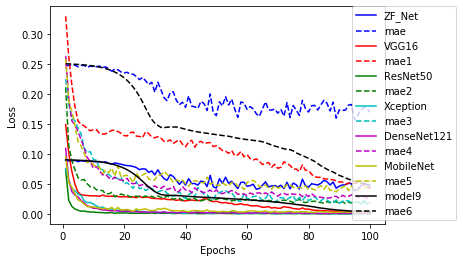

In [ ]:


mse = history.history['loss'] 
mae = history.history['mean_absolute_error']
mse1 = history1.history['loss']
mae1 = history1.history['mean_absolute_error']
mse2 = history2.history['loss']
mae2 = history2.history['mean_absolute_error']
mse3 = history3.history['loss']
mae3 = history3.history['mean_absolute_error']
mse4 = history4.history['loss']
mae4 = history4.history['mean_absolute_error']
mse5 = history5.history['loss']
mae5 = history5.history['mean_absolute_error']

mse6 = history6.history['loss']
mae6 = history6.history['mean_absolute_error']
# mse7 = history7.history['loss']
# mae7 = history7.history['mean_absolute_error']
# mse8 = history8.history['loss']
# mae8 = history8.history['mean_absolute_error']

# model = ZF_Net()
# model1 = VGG16()
# model2 = ResNet50()
# model3 = Xception()
# model4 = DenseNet121()
# model5 = MobileNet()
# model6 = get_model9()

epochs = range(1,len(mse) +1)
plt.plot(epochs, mse, 'b', label='ZF_Net')
plt.plot(epochs, mae, 'b--', label='mae')
plt.plot(epochs, mse1, 'r', label='VGG16')
plt.plot(epochs, mae1, 'r--', label='mae1')
plt.plot(epochs, mse2, 'g', label='ResNet50')
plt.plot(epochs, mae2, 'g--', label='mae2')
plt.plot(epochs, mse3, 'c', label='Xception')
plt.plot(epochs, mae3, 'c--', label='mae3')
plt.plot(epochs, mse4, 'm', label='DenseNet121')
plt.plot(epochs, mae4, 'm--', label='mae4')
plt.plot(epochs, mse5, 'y', label='MobileNet')
plt.plot(epochs, mae5, 'y--', label='mae5')
plt.plot(epochs, mse6, 'k', label='model9')
plt.plot(epochs, mae6, 'k--', label='mae6')
# plt.plot(epochs, mse7, '#9467bd', label='mse7')
# plt.plot(epochs, mae7, '#9467bd',linestyle='dashed', label='mae7')
# plt.plot(epochs, mse8, '#e377c2', label='mse8')
# plt.plot(epochs, mae8, '#e377c2',linestyle='dashed', label='mae8')

plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.show() 
# plt.savefig('/content/drive/My Drive/original(10%kept)_6models.png' ,dpi=2400)